# Extracting ROI and Dimensionality Reduction

In this notebook, we will parcellate the brain using the localizer runs in the experiment, in order to build masks eventually. 

## Goals
* Extract visual system masks from the localizer runs.
* Explore dimensionality reduction.

In [1]:
from packages import *
%matplotlib inline

In [24]:
from nilearn.decomposition import DictLearning
from nilearn.regions import Parcellations, RegionExtractor
from nilearn.image.image import mean_img, index_img
from scipy.ndimage.measurements import label
from collections import Counter
from _1_file_acquisition import get_subject_images

We will need to write some new code to get the localizer files.

In [3]:
def get_localizer_files(subject, data_dir):
    output = {}
    output['localizer'] = localizer =  {}
    fmriprep_dir = os.path.join(data_dir, 'fmri', 'fmriprep', get_subject_dir(subject))
    for ses in SESSIONS:
        session = {}
        ses_dir = os.path.join(fmriprep_dir, get_session_dir(ses), 'func')
        files = os.listdir(ses_dir)
        for file in files:
            if 'localizer' not in file:
                continue
            if 'preproc' in file:
                session['preproc'] = load_file(os.path.join(ses_dir, file))[0]
            elif '-aseg' in file:
                session['aseg'] = load_file(os.path.join(ses_dir, file))[0]
            elif 'brainmask' in file:
                session['brainmask'] = load_file(os.path.join(ses_dir, file))[0]
        if len(session) != 0:
            localizer[ses] = session
    spm_anat = get_subject_images(subject=subject, data_dir=data_dir, spm_reqs='*', anat_image=True)
    output['spm'] = spm_anat['spm']
    output['anat'] = spm_anat['anat']
    return output

In [4]:
images = get_localizer_files(subject=1, data_dir=DATA_DIR)

In [5]:
timeseries = [images['localizer'][i]['preproc'] for i in images['localizer']]

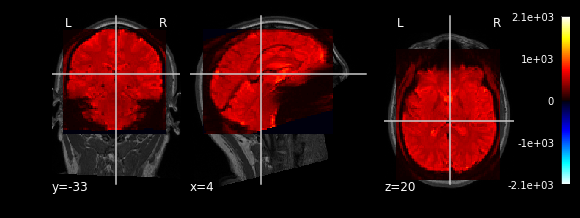

In [31]:
PLOTS['stat_map'](index_img(combined_img, 50), images['anat']['preproc'])

## Dictionary Learning

Let's begin by running Dictionary Learning to decompose the whole brain into components.

In [32]:
n_comps = 17
dict_learn = DictLearning(n_components=n_comps, smoothing_fwhm=9.,standardize=True,
                        random_state=0, n_jobs=-2, memory='nilearn_cache', memory_level=1)
dict_learn.fit(combined_img)
components_img = dict_learn.components_img_

/home/kaan/anaconda3/envs/brain-decoding_3.6/lib/python3.6/site-packages/nilearn/_utils/cache_mixin.py:302: UserWarning: memory_level is currently set to 0 but a Memory object has been provided. Setting memory_level to 1.
  warnings.warn("memory_level is currently set to 0 but "
/home/kaan/anaconda3/envs/brain-decoding_3.6/lib/python3.6/site-packages/nilearn/input_data/multi_nifti_masker.py:203: UserWarning: Persisting input arguments took 14.91s to run.
If this happens often in your code, it can cause performance problems 
(results will be correct in all cases). 
The reason for this is probably some large input arguments for a wrapped
 function (e.g. large strings).
THIS IS A JOBLIB ISSUE. If you can, kindly provide the joblib's team with an
 example so that they can fix the problem.
  **mask_args)


KeyboardInterrupt: 

In [114]:
if save:
    numpy_save(components_img.get_fdata(), 'comps_dict-learning_{}'.format(n_comps), os.path.join(get_subject_dir(subject), 'roi'))

In [11]:
comps = [index_img(components_img, i) for i in xrange(n_comps)]
p = None
C = {}
C_ = {}
for i in xrange(n_comps):
    C[i] = Counter(comps[i].get_fdata().flatten())
print 'by all {} components, {}% of all voxels are accounted.'.format(n_comps, np.sum([np.product(shp) - C[i][0] for i in range(n_comps)])*100 / np.product(shp))

by all 17 components, 70.9955425437% of all voxels are accounted.


In [ ]:
PLOTS['prob_atlas'](components_img, images['anat']['preproc'], view_type='filled_contours',
                         title='Dictionary Learning w/ {} comps'.format(n_comps), cut_coords =(0, -70, 28))

### Investigating the components

In [39]:
def remove_disconnected_comps(mask, threshold = 0.90):
    """
    @ labeled_data: array-like, the voxels labeled by group
    @ threshold: double, percentage of non-zero data points that will not be modified
    """
    mask_filtered = np.array(mask)
    connection = np.ones((3,3,3))
    labeled, ncomponents = label(mask_filtered, connection)
    c = Counter(labeled.flatten())
    c.pop(0, None) # get rid of 0s
    N = sum(c.values()) # total data points
    remaining = N # number of data points untouched
    uncommon_to_common = sorted(c, key=c.get)
    removed = 0
    for group_label in uncommon_to_common[:]: 
        group_size = c.get(group_label)
        if remaining - group_size < N*threshold:
            break
        mask_filtered[labeled == group_label] = 0
        remaining-=group_size
        removed+=1
    print 'Removed {} out of {} non-zero voxels, eliminating {} out of {} connected components'.format(N-remaining, N, removed, ncomponents)
    return mask_filtered

Running all of the components at the same is RAM heavy, let's do it one at a time below.

In [35]:
# i = 14
# if run:
#     p = PLOTS['html'](comps[i], anat_file, threshold ='auto', cut_coords=[4, -95, 10]) 
# else:
#     p = PLOTS['roi'](comps[i], anat_file, threshold ='auto', cut_coords=[4, -95, 10]) 
# print '{}% of all voxels.'.format((np.product(shp) - C[i][0]) * 100 / np.product(shp))
# p

### Primary visual

3.1083504774% of all voxels.


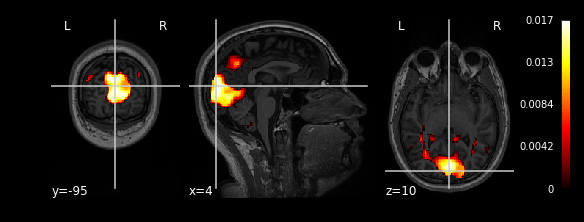

In [37]:
primary_viz_i = 14
if run:
    p = PLOTS['html'](comps[primary_viz_i], anat_file, threshold ='auto', cut_coords=[4, -95, 10]) 
else:
    p = PLOTS['stat_map'](comps[primary_viz_i], anat_file, threshold ='auto', cut_coords=[4, -95, 10]) 
print '{}% of all voxels.'.format((np.product(shp) - C[primary_viz_i][0]) * 100 / np.product(shp))
p

In [43]:
arr = np.array(comps[primary_viz_i].get_fdata())
arr[arr <= 0.] = np.nan
qth = np.nanpercentile(arr, 10)
arr = np.nan_to_num(arr)
arr[arr > qth] = 1.
arr[arr <= qth] = 0.
primary_viz_mask= arr.astype(int)
primary_viz_mask = remove_disconnected_comps(primary_viz_mask)
C_['primary_viz'] = Counter(primary_viz_mask.flatten())
print '{}% of primary visual voxels ({}) remain.'.format(100 * C_['primary_viz'][1] / (np.product(shp) - C[primary_viz_i][0]), C_['primary_viz'][1])
if run:
    p = PLOTS['html'](nibabel.Nifti1Image(removed,affine), anat_file, title='Primary Visual Mask')
p

Removed 1218 out of 12727 non-zero voxels, eliminating 20 out of 22 connected components
81.381699901% of primary visual voxels (11509) remain.


### Lateral and medial visual

3.4022172988% of all voxels.


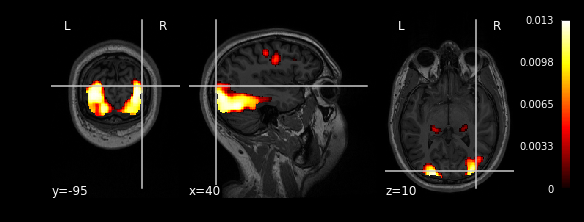

In [58]:
lateral_viz_i = 2
if run:
    p = PLOTS['html'](comps[lateral_viz_i], anat_file, threshold ='auto', cut_coords=[4, -95, 10]) 
else:
    p = PLOTS['stat_map'](comps[lateral_viz_i], anat_file, threshold ='auto', cut_coords=[40, -95, 10]) 

print '{}% of all voxels.'.format((np.product(shp) - C[lateral_viz_i][0]) * 100 / np.product(shp))
p

In [45]:
arr = np.array(comps[lateral_viz_i].get_fdata())
arr[arr <= 0.] = np.nan
qth = np.nanpercentile(arr, 10)
arr = np.nan_to_num(arr)
arr[arr > qth] = 1.
arr[arr <= qth] = 0.
lateral_viz_mask= arr.astype(int)
lateral_viz_mask = remove_disconnected_comps(lateral_viz_mask)
C_['lateral_viz'] = Counter(lateral_viz_mask.flatten())
print '{}% of lateral visual voxels ({}) remain.'.format(100 * C_['lateral_viz'][1] / (np.product(shp) - C[lateral_viz_i][0]), C_['lateral_viz'][1])
if run:
    p = PLOTS['html'](nibabel.Nifti1Image(lateral_viz_mask,affine), anat_file, title='Lateral Visual Mask')
p

Removed 1057 out of 13931 non-zero voxels, eliminating 14 out of 15 connected components
83.1707474643% of lateral visual voxels (12874) remain.


### Gray matter mask

Using the aseg_roi template, we can easily create a mask region for the gray matter areas and exclude the cerebellum.

In [50]:
labels = load_file(os.path.join(MISC_DIR, 'aseg_labels.tsv'))[0]
regions_wanted = ['Left-Cerebral-Cortex', 'Right-Cerebral-Cortex']
labels.head(5)

,ID,LABEL
0,0,Unknown
1,1,Left-Cerebral-Exterior
2,2,Left-Cerebral-White-Matter
3,3,Left-Cerebral-Cortex
4,4,Left-Lateral-Ventricle


In [51]:
regions = list(labels[labels['LABEL'].isin(regions_wanted)].ID)
print 'Will look for voxels with values in {}'.format(regions)
labels[labels['LABEL'].isin(regions_wanted)]

Will look for voxels with values in [3, 42]


,ID,LABEL
3,3,Left-Cerebral-Cortex
42,42,Right-Cerebral-Cortex


In [52]:
# TO SEE WHAT THE ASEG FILE LOOKS LIKE
# if run:
#     p = PLOTS['html'](aseg, anat_file, title='aseg_roi')
# p

In [53]:
gm_mask = np.isin(aseg.get_fdata().astype(int), regions).astype(int)

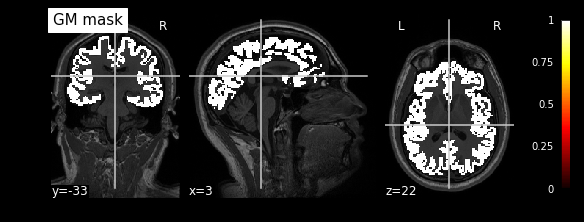

In [54]:
if run:
    p = PLOTS['html'](nibabel.Nifti1Image(gm_mask,affine), anat_file, title='GM mask')
else:
    p = PLOTS['stat_map'](nibabel.Nifti1Image(gm_mask,affine), anat_file, title='GM mask')

p

In [16]:
if save:
    numpy_save(gm_mask, 'mask_gm', os.path.join(get_subject_dir(subject), 'roi'))

### Parcellations - ward

In [100]:
n_parcels = 20000
if run:
    ward = Parcellations(method='ward', n_parcels=n_parcels,
                     standardize=False, smoothing_fwhm=6.,
                     memory='nilearn_cache',n_jobs=-2, memory_level=4)
    ward.fit(timeseries)
    ward_labels_img = ward.labels_img_

[MultiNiftiMasker.fit] Loading data from [Nifti1Image('/home/kaandonbekci/data/scp-sub-CSI2/ses-02/func/sub-CSI2_ses-02_task-localizer_bold_space-T1w_preproc.nii.gz'), Nifti1Image('/home/kaandonbekci/data/scp-sub-CSI2/ses-06/func/sub-CSI2_se
[MultiNiftiMasker.fit] Computing mask
[MultiNiftiMasker.transform] Resampling mask
[Parcellations] Loading data
[MultiNiftiMasker.transform_single_imgs] Loading data from Nifti1Image('/home/kaandonbekci/data/scp-sub-CSI2/ses-02/func/sub-CSI2_ses-02_task-localizer_bold_space-T1w_preproc.nii.gz')
[MultiNiftiMasker.transform_single_imgs] Smoothing images
[MultiNiftiMasker.transform_single_imgs] Loading data from Nifti1Image('/home/kaandonbekci/data/scp-sub-CSI2/ses-08/func/sub-CSI2_ses-08_task-localizer_bold_space-T1w_preproc.nii.gz')
[MultiNiftiMasker.transform_single_imgs] Loading data from Nifti1Image('/home/kaandonbekci/data/scp-sub-CSI2/ses-06/func/sub-CSI2_ses-06_task-localizer_bold_space-T1w_preproc.nii.gz')
[MultiNiftiMasker.transform_single_i

/home/kaandonbekci/.local/lib/python2.7/site-packages/nilearn/input_data/base_masker.py:100: JobLibCollisionWarning: Cannot detect name collisions for function 'nifti_masker_extractor'
  memory_level=memory_level)(imgs)


[MultiNiftiMasker.transform_single_imgs] Extracting region signals


/home/kaandonbekci/.local/lib/python2.7/site-packages/nilearn/input_data/base_masker.py:100: JobLibCollisionWarning: Cannot detect name collisions for function 'nifti_masker_extractor'
  memory_level=memory_level)(imgs)
/home/kaandonbekci/.local/lib/python2.7/site-packages/nilearn/input_data/base_masker.py:100: JobLibCollisionWarning: Cannot detect name collisions for function 'nifti_masker_extractor'
  memory_level=memory_level)(imgs)
/home/kaandonbekci/.local/lib/python2.7/site-packages/nilearn/input_data/base_masker.py:100: JobLibCollisionWarning: Cannot detect name collisions for function 'nifti_masker_extractor'
  memory_level=memory_level)(imgs)
/home/kaandonbekci/.local/lib/python2.7/site-packages/nilearn/input_data/base_masker.py:100: JobLibCollisionWarning: Cannot detect name collisions for function 'nifti_masker_extractor'
  memory_level=memory_level)(imgs)
/home/kaandonbekci/.local/lib/python2.7/site-packages/nilearn/input_data/base_masker.py:100: JobLibCollisionWarning: Can

[MultiNiftiMasker.transform_single_imgs] Cleaning extracted signals
[MultiNiftiMasker.transform_single_imgs] Cleaning extracted signals
[MultiNiftiMasker.transform_single_imgs] Cleaning extracted signals
[MultiNiftiMasker.transform_single_imgs] Cleaning extracted signals
[MultiNiftiMasker.transform_single_imgs] Cleaning extracted signals
[MultiNiftiMasker.transform_single_imgs] Cleaning extracted signals
[MultiNiftiMasker.transform_single_imgs] Cleaning extracted signals
[MultiNiftiMasker.transform_single_imgs] Loading data from Nifti1Image('/home/kaandonbekci/data/scp-sub-CSI2/ses-15/func/sub-CSI2_ses-15_task-localizer_bold_space-T1w_preproc.nii.gz')
[MultiNiftiMasker.transform_single_imgs] Smoothing images
[MultiNiftiMasker.transform_single_imgs] Extracting region signals
[MultiNiftiMasker.transform_single_imgs] Cleaning extracted signals
________________________________________________________________________________
[Memory] Calling sklearn.utils.extmath.randomized_svd...
randomize

Comparing the ward-reduced data to the functional data is a way to see if the mask we created is appropriate

In [101]:
comp_i = 0

In [102]:
mean_func_localizer_img = mean_img(timeseries[comp_i])
vmin = np.min(mean_func_localizer_img.get_fdata())
vmax = np.max(mean_func_localizer_img.get_fdata())

In [103]:
ward_reduced = ward.transform(timeseries)

________________________________________________________________________________
[Memory] Calling nilearn.regions.parcellations._labels_masker_extraction...
_labels_masker_extraction(<nibabel.nifti1.Nifti1Image object at 0x7fc9a8e98550>, NiftiLabelsMasker(background_label=0, detrend=False, dtype=None,
         high_pass=None,
         labels_img=<nibabel.nifti1.Nifti1Image object at 0x7fc9a8e98490>,
         low_pass=None,
         mask_img=<nibabel.nifti1.Nifti1Image object at 0x7fc9a8e98590>,
         memory=Memory(cachedir='nilearn_cache/joblib'), memory_level=4,
         resampling_target='data', smoothing_fwhm=6.0, standardize=False,
         t_r=None, verbose=1), 
None)
[Parcellations.transform] loading data from Nifti1Image(
shape=(72, 92, 70),
affine=array([[   2. ,    0. ,    0. ,  -66.5],
       [   0. ,    2. ,    0. , -109. ],
       [   0. ,    0. ,    2. ,  -48. ],
       [   0. ,    0. ,    0. ,    1.
[Parcellations.transform] loading data from Nifti1Image(
shape=(72, 92

/home/kaandonbekci/.local/lib/python2.7/site-packages/nilearn/input_data/base_masker.py:100: JobLibCollisionWarning: Cannot detect name collisions for function 'nifti_labels_masker_extractor'
  memory_level=memory_level)(imgs)


______________________________________________________smooth_img - 14.0s, 0.2min
[NiftiLabelsMasker.transform_single_imgs] Extracting region signals
______________________________________________________smooth_img - 13.0s, 0.2min
[NiftiLabelsMasker.transform_single_imgs] Extracting region signals
________________________________________________________________________________
[Memory] Calling nilearn.input_data.nifti_labels_masker.nifti_labels_masker_extractor...
nifti_labels_masker_extractor(<nibabel.nifti1.Nifti1Image object at 0x7fc96c71ca10>)


/home/kaandonbekci/.local/lib/python2.7/site-packages/nilearn/input_data/base_masker.py:100: JobLibCollisionWarning: Cannot detect name collisions for function 'nifti_labels_masker_extractor'
  memory_level=memory_level)(imgs)
/home/kaandonbekci/.local/lib/python2.7/site-packages/nilearn/input_data/base_masker.py:100: JobLibCollisionWarning: Cannot detect name collisions for function 'nifti_labels_masker_extractor'
  memory_level=memory_level)(imgs)


________________________________________________________________________________
[Memory] Calling nilearn.input_data.nifti_labels_masker.nifti_labels_masker_extractor...
nifti_labels_masker_extractor(<nibabel.nifti1.Nifti1Image object at 0x7fc9a1138ad0>)
________________________________________________________________________________
[Memory] Calling nilearn.input_data.nifti_labels_masker.nifti_labels_masker_extractor...
nifti_labels_masker_extractor(<nibabel.nifti1.Nifti1Image object at 0x7fc96c716b90>)
______________________________________________________smooth_img - 13.9s, 0.2min
[NiftiLabelsMasker.transform_single_imgs] Extracting region signals


/home/kaandonbekci/.local/lib/python2.7/site-packages/nilearn/input_data/base_masker.py:100: JobLibCollisionWarning: Cannot detect name collisions for function 'nifti_labels_masker_extractor'
  memory_level=memory_level)(imgs)


________________________________________________________________________________
[Memory] Calling nilearn.input_data.nifti_labels_masker.nifti_labels_masker_extractor...
nifti_labels_masker_extractor(<nibabel.nifti1.Nifti1Image object at 0x7fc96c716c50>)
______________________________________________________smooth_img - 15.2s, 0.3min
[NiftiLabelsMasker.transform_single_imgs] Extracting region signals
____________________________________nifti_labels_masker_extractor - 7.6s, 0.1min
[NiftiLabelsMasker.transform_single_imgs] Cleaning extracted signals


/home/kaandonbekci/.local/lib/python2.7/site-packages/nilearn/input_data/base_masker.py:100: JobLibCollisionWarning: Cannot detect name collisions for function 'nifti_labels_masker_extractor'
  memory_level=memory_level)(imgs)


________________________________________________________________________________
[Memory] Calling nilearn.signal.clean...
clean(array([[651.238406, ..., 611.870266],
       ...,
       [654.238169, ..., 615.841098]]), standardize=False, sessions=None, detrend=False, confounds=None, low_pass=None, t_r=None, high_pass=None)
____________________________________________________________clean - 0.3s, 0.0min
________________________________________________________________________________
[Memory] Calling nilearn.input_data.nifti_labels_masker.nifti_labels_masker_extractor...
nifti_labels_masker_extractor(<nibabel.nifti1.Nifti1Image object at 0x7fc96c734d10>)
______________________________________________filter_and_extract - 26.5s, 0.4min
________________________________________labels_masker_extraction - 28.6s, 0.5min
____________________________________nifti_labels_masker_extractor - 8.3s, 0.1min
[NiftiLabelsMasker.transform_single_imgs] Cleaning extracted signals
____________________________

/home/kaandonbekci/.local/lib/python2.7/site-packages/nilearn/input_data/base_masker.py:100: JobLibCollisionWarning: Cannot detect name collisions for function 'nifti_labels_masker_extractor'
  memory_level=memory_level)(imgs)


______________________________________________filter_and_extract - 27.3s, 0.5min
________________________________________labels_masker_extraction - 29.7s, 0.5min
________________________________________________________________________________
[Memory] Calling nilearn.input_data.base_masker.filter_and_extract...
filter_and_extract(<nibabel.nifti1.Nifti1Image object at 0x7fc96c71c110>, <nilearn.input_data.nifti_labels_masker._ExtractionFunctor object at 0x7fc96c745710>, 
{ 'background_label': 0,
  'detrend': False,
  'dtype': None,
  'high_pass': None,
  'labels_img': <nibabel.nifti1.Nifti1Image object at 0x7fc9a90a5090>,
  'low_pass': None,
  'mask_img': <nibabel.nifti1.Nifti1Image object at 0x7fc96c71cb50>,
  'smoothing_fwhm': 6.0,
  'standardize': False,
  't_r': None,
  'target_affine': None,
  'target_shape': None}, dtype=None, memory_level=4, memory=Memory(cachedir='nilearn_cache/joblib'), verbose=1, confounds=None)
[NiftiLabelsMasker.transform_single_imgs] Loading data from Nifti1

________________________________________________________________________________
[Memory] Calling nilearn.input_data.nifti_labels_masker.nifti_labels_masker_extractor...
nifti_labels_masker_extractor(<nibabel.nifti1.Nifti1Image object at 0x7fc9a90a5750>)
____________________________________nifti_labels_masker_extractor - 4.3s, 0.1min
[NiftiLabelsMasker.transform_single_imgs] Cleaning extracted signals
________________________________________________________________________________
[Memory] Calling nilearn.signal.clean...
clean(array([[658.400505, ..., 609.305143],
       ...,
       [649.076496, ..., 613.128353]]), standardize=False, sessions=None, detrend=False, confounds=None, low_pass=None, t_r=None, high_pass=None)
____________________________________________________________clean - 0.1s, 0.0min
______________________________________________filter_and_extract - 18.0s, 0.3min
________________________________________labels_masker_extraction - 20.3s, 0.3min


In [104]:
ward_compressed = ward.inverse_transform(ward_reduced)

________________________________________________________________________________
[Memory] Calling nilearn.regions.signal_extraction.signals_to_img_labels...
signals_to_img_labels(memmap([[651.238406, ..., 611.870266],
        ...,
        [654.238169, ..., 615.841098]]), 
<nibabel.nifti1.Nifti1Image object at 0x7fc9a8e98490>, <nibabel.nifti1.Nifti1Image object at 0x7fc9a8e98b50>)
________________________________________________________________________________
[Memory] Calling nilearn.regions.signal_extraction.signals_to_img_labels...
signals_to_img_labels(memmap([[617.541619, ..., 597.269218],
        ...,
        [623.539642, ..., 599.40478 ]]), 
<nibabel.nifti1.Nifti1Image object at 0x7fc9a8e98e90>, <nibabel.nifti1.Nifti1Image object at 0x7fc9a8e98490>)
________________________________________________________________________________
[Memory] Calling nilearn.regions.signal_extraction.signals_to_img_labels...
signals_to_img_labels(memmap([[685.103478, ..., 631.893407],
        ...,
   

The reduced representation flattens all of the parcels.

The compressed representation returns to the original shape but comressed.

In [105]:
print ward_compressed[comp_i].shape
assert ward_compressed[comp_i].shape == timeseries[comp_i].shape

(72, 92, 70, 141)


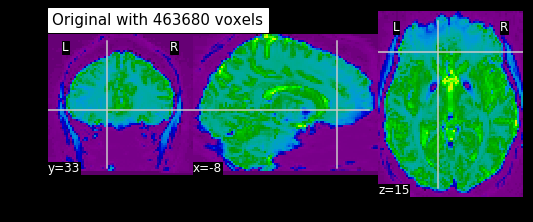

In [106]:
PLOTS['epi'](mean_img(timeseries[comp_i]),title= 'Original with {} voxels'.format(np.product(shp)),cut_coords=(-8,33,15),vmax=vmax, vmin = vmin)

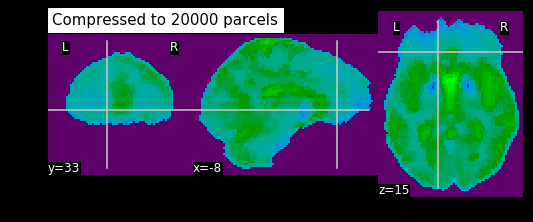

In [107]:
PLOTS['epi'](mean_img(ward_compressed[comp_i]), title='Compressed to {} parcels'.format(n_parcels), cut_coords=(-8,33,15), vmax=vmax, vmin = vmin)

In [108]:
if save:
    save_pickle(ward_labels_img, 'parcellation_ward_{}'.format(n_parcels), roi_dir)